In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np

vaers = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VAERS/2021VAERSDATA.csv', encoding = 'ISO-8859-1')
vaers_vax = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VAERS/2021VAERSVAX.csv')

데이터는 백신을 접종받은 사람의 id를 공유하는 2개의 data set을 사용하며,

vaers는 접종받은 사람의 정보(나이, 사망 여부 등)

vaers_vax는 접종받은 vaccine 정보를 담고 있다.

covid19 백신을 접종받은 사람을 대상으로 부작용 정도(사망여부, 입원기간 등)를 점수화하여 그것을 target으로 진행하려 한다.

(데이터 수집 기관에 따르면 사망 등 치명적인 부작용에 백신 이외의 외부 환경 요인이 작용하였을 가능성은 현저히 낮다)

데이터 출처 : https://vaers.hhs.gov/data/datasets.html? (2021년 데이터)

데이터 설명 : https://vaers.hhs.gov/docs/VAERSDataUseGuide_November2020.pdf

In [4]:
# COVID19 vaccine recipient 만 추출한다
covid19_recip_id = vaers_vax[vaers_vax['VAX_TYPE']=='COVID19'].VAERS_ID

vaers_vax_covid19 = vaers_vax[vaers_vax['VAERS_ID'].isin(covid19_recip_id)]
vaers_covid19 = vaers[vaers['VAERS_ID'].isin(covid19_recip_id)]

vaers_vax data set 수정

vaccine 종류를 알 수 없는 data들은 모든 정보가 결측값인 것이 대부분 이었고, 그나마 vaccine lot 가 기록되어있는 id 919620에 대해서는 covid19 백신의 lot와 같으므로 중복되어 기입된 값이라고 생각할 수 있음

따라서 vaccine 종류가 unknown인 data 모두 제거

In [5]:
#중복 id 추출
dup_vaers_vax = vaers_vax_covid19['VAERS_ID'].value_counts()
dup_vaers_vax_id = dup_vaers_vax[dup_vaers_vax.values>=2].index

#중복 id중 vaccine 종류가 unknown인 data 제거
vaers_vax_covid19.drop(index=vaers_vax_covid19[vaers_vax_covid19.VAX_TYPE=='UNK'].index, inplace=True)

#완벽하게 같은 row 제거
vaers_vax_covid19.drop_duplicates(inplace=True)

#같은 회사의 제품을 접종하였으면 한개의 row만 남겨두고 제거
dup_vaers_vax = vaers_vax_covid19['VAERS_ID'].value_counts()
dup_vaers_vax_id = dup_vaers_vax[dup_vaers_vax.values>=2].index
dup_vaers_vax_covid19 = vaers_vax_covid19[vaers_vax_covid19.VAERS_ID.isin(dup_vaers_vax_id)]
vaers_vax_covid19.drop(index=vaers_vax_covid19[vaers_vax_covid19.VAERS_ID.isin(dup_vaers_vax_id)].index, inplace=True)

#아래 3개의 id에 대해서는 서로다른 2개의 백신을 접종했다고 기록되어 있음. 아래 3개 데이터 이외에는 중복값으로 취급
dup_2_vaers_vax_covid19 = dup_vaers_vax_covid19.loc[dup_vaers_vax_covid19.VAERS_ID.isin([967274, 973267])]
dup_vaers_vax_covid19.drop(index=dup_vaers_vax_covid19[dup_vaers_vax_covid19.VAERS_ID.isin([967274, 973267])].index, inplace=True)

In [6]:
#중복 id 제거
dup_vaers_vax_covid19.drop_duplicates(['VAERS_ID'], inplace=True)

#정리된 vaers_vax 데이터 셋
vaers_vax_covid19 = pd.concat([vaers_vax_covid19, dup_vaers_vax_covid19])

#vaers_vax data set 의 feature VAERS_ID를 기준으로 vaers + vaers_vax 데이터 셋 합침
vaers_covid19_merge = pd.merge(vaers_vax_covid19, vaers_covid19, on='VAERS_ID', how='left')

In [7]:
#치명적인 증상의 발생 여부를 'fatal' feature에 저장
vaers_covid19_merge['fatal'] = 0

for row in vaers_covid19_merge.index :
  if ((vaers_covid19_merge.loc[row, 'DIED']=='Y') | (vaers_covid19_merge.loc[row, 'L_THREAT']=='Y')) :
      vaers_covid19_merge.loc[row, 'fatal'] = 1

In [133]:
#치명적인 증상의 정도를 'fatal_score' feature에 저장
vaers_covid19_merge['fatal_score'] = 0

for row in vaers_covid19_merge.index :
  if (vaers_covid19_merge.loc[row, 'DIED']=='Y') :
    vaers_covid19_merge.loc[row, 'fatal_score'] = 2
  elif (vaers_covid19_merge.loc[row, 'L_THREAT']=='Y') :
    vaers_covid19_merge.loc[row, 'fatal_score'] = 1

사용할 feature 선택 : VAERS_ID, VAX_TYPE(백신 종류), VAX_MANU(백신 제조사), VAX_DOSE_SERIES(복용량), VAX_ROUTE(백신 접종 방법), VAX_SITE(백신 접종 위치), STATE(주), AGE_YRS(나이), SEX(성별), V_ADMINBY(백신 관리 기관), BIRTH_DEFECT(백신에 영향 받을 수 있는 선천장애 여부),

target으로 사용할 feature : DIED(사망여부), L_THREAT(치명적인 증상 여부), X_STAY(장기입원여부), DISABLE(백신으로 인한 장애 여부) --> 10점을 최고점으로, 사망시 10점을, 다른 3가지 조건을 가졌을 경우 각각 3점씩 부여함

HOSPITAL(입원여부)는 심각한 부작용과 직접적인 연관이 적다고 판단하여 target에서 제외함

In [9]:
vaers_covid19_merge['fatal'].value_counts() #부작용있음:없음 = 858:2734 (imbalanced)

0    2862
1     730
Name: fatal, dtype: int64

In [134]:
vaers_covid19_merge['fatal_score'].value_counts()

0    2858
2     428
1     300
Name: fatal_score, dtype: int64

feature 전처리

In [11]:
#값이 unknown일 때 NaN으로 기입되거나 unknown이라고 기입되는데, 이를 통합
vaers_covid19_merge['VAX_MANU'].fillna('UNKNOWN MANUFACTURER', inplace=True)
vaers_covid19_merge['V_ADMINBY'].fillna('UNK', inplace=True)
# vaers_covid19_merge['VAX_ROUTE'].fillna('UN', inplace=True)
vaers_covid19_merge['SEX'].fillna('U', inplace=True)
vaers_covid19_merge['fatal'].fillna(0, inplace=True)

#숫자형 데이터인 VAX_DOSE_SERIES의 경우 7+라는 값 때문에 ordinal encoding 이후 새로운 값에 mapping 되므로 7+를 7로 변경
vaers_covid19_merge['VAX_DOSE_SERIES'].replace('UNK', np.nan, inplace=True)
vaers_covid19_merge['VAX_DOSE_SERIES'].replace('7+', 7, inplace=True)
# vaers_covid19_merge['VAX_DOSE_SERIES'].fillna(0, inplace=True)
vaers_covid19_merge['VAX_DOSE_SERIES'] = vaers_covid19_merge['VAX_DOSE_SERIES'].astype('float')

#BIRTH_DEFECT의 경우 편의상 N=0, Y=1로 변경
vaers_covid19_merge['BIRTH_DEFECT'].replace('Y', 1, inplace=True)
vaers_covid19_merge['BIRTH_DEFECT'].fillna(0, inplace=True)

#만성질환 및 병력

In [12]:
vaers_covid19_merge['HISTORY'] = vaers_covid19_merge['HISTORY'].str.lower()

In [13]:
vaers_covid19_merge['HISTORY'].replace(['comments: list of non-encoded patient relevant history: patient other relevant history 1: none', 
                                        'none', 'unknown', 'no'], np.nan, inplace=True)

In [14]:
vaers_covid19_merge['HISTORY'].value_counts()

asthma                                                                                           23
hypertension                                                                                     15
hypothyroidism                                                                                   11
diabetes                                                                                         10
medical history/concurrent conditions: hypertension                                               7
                                                                                                 ..
asthma, copd, htn, hx of breast cancer                                                            1
medical history/concurrent conditions: pain                                                       1
medical history/concurrent conditions: breast cancer female; latex allergy; shellfish allergy     1
medical history/concurrent conditions: surgery; tachycardia                                       1


In [15]:
vaers_covid19_merge['HISTORY'].fillna('', inplace=True)

In [16]:
# vaers_covid19_merge['HISTORY'][(vaers_covid19_merge['cardiac_disorder']==0)
#                                &(vaers_covid19_merge['HISTORY'].str.contains('cvd'))].values

In [17]:
#호흡기질환 환자

vaers_covid19_merge['pulmonary_disoreder'] = 0
vaers_covid19_merge['pulmonary_disoreder'][(vaers_covid19_merge['HISTORY'].str.contains('pulmonary'))|(vaers_covid19_merge['HISTORY'].str.contains('asthma'))
                                 |(vaers_covid19_merge['HISTORY'].str.contains('lung'))|(vaers_covid19_merge['HISTORY'].str.contains('copd'))
                                 |(vaers_covid19_merge['HISTORY'].str.contains('bronchitis'))|(vaers_covid19_merge['HISTORY'].str.contains('pneumonia'))] = 1
vaers_covid19_merge['pulmonary_disoreder'].value_counts()

0    3323
1     269
Name: pulmonary_disoreder, dtype: int64

In [18]:
vaers_covid19_merge['hypertension'] = 0
vaers_covid19_merge['hypertension'][(vaers_covid19_merge['HISTORY'].str.contains('hypertension'))|(vaers_covid19_merge['HISTORY'].str.contains('high blood'))
|(vaers_covid19_merge['HISTORY'].str.contains('blood pressure'))]=1
vaers_covid19_merge['hypertension'].value_counts()

0    3286
1     306
Name: hypertension, dtype: int64

In [19]:
vaers_covid19_merge['high_cholesterol'] = 0
vaers_covid19_merge['high_cholesterol'][(vaers_covid19_merge['HISTORY'].str.contains('cholest'))]=1
vaers_covid19_merge['high_cholesterol'].value_counts()

0    3548
1      44
Name: high_cholesterol, dtype: int64

In [20]:
vaers_covid19_merge['arthritis'] = 0
vaers_covid19_merge['arthritis'][(vaers_covid19_merge['HISTORY'].str.contains('arthritis'))|
                                 (vaers_covid19_merge['HISTORY'].str.contains('joint'))]=1
vaers_covid19_merge['arthritis'].value_counts()

0    3504
1      88
Name: arthritis, dtype: int64

In [21]:
vaers_covid19_merge['cardiac_disorder'] = 0
vaers_covid19_merge['cardiac_disorder'][(vaers_covid19_merge['HISTORY'].str.contains('cardiac'))|(vaers_covid19_merge['HISTORY'].str.contains('heart'))
|(vaers_covid19_merge['HISTORY'].str.contains('cardio'))|(vaers_covid19_merge['HISTORY'].str.contains('cvd'))] = 1
vaers_covid19_merge['cardiac_disorder'].value_counts()

0    3451
1     141
Name: cardiac_disorder, dtype: int64

In [22]:
vaers_covid19_merge['diabetes'] = 0
vaers_covid19_merge['diabetes'][(vaers_covid19_merge['HISTORY'].str.contains('diabetes'))
                                |(vaers_covid19_merge['HISTORY'].str.contains('dm'))] = 1
vaers_covid19_merge['diabetes'][(vaers_covid19_merge['HISTORY'].str.contains('admission'))] = 0
vaers_covid19_merge['diabetes'].value_counts()

0    3366
1     226
Name: diabetes, dtype: int64

In [23]:
vaers_covid19_merge['kidney_disorder'] = 0
vaers_covid19_merge['kidney_disorder'][(vaers_covid19_merge['HISTORY'].str.contains('kidney'))|(vaers_covid19_merge['HISTORY'].str.contains('ckd'))] = 1
vaers_covid19_merge['kidney_disorder'].value_counts()

0    3509
1      83
Name: kidney_disorder, dtype: int64

In [24]:
vaers_covid19_merge['depression'] = 0
vaers_covid19_merge['depression'][(vaers_covid19_merge['HISTORY'].str.contains('depression'))|(vaers_covid19_merge['HISTORY'].str.contains('depressive'))] = 1
vaers_covid19_merge['depression'].value_counts()

0    3477
1     115
Name: depression, dtype: int64

In [25]:
vaers_covid19_merge['alzheimer'] = 0
vaers_covid19_merge['alzheimer'][(vaers_covid19_merge['HISTORY'].str.contains('alz'))] = 1
vaers_covid19_merge['alzheimer'].value_counts()

0    3567
1      25
Name: alzheimer, dtype: int64

In [26]:
vaers_covid19_merge['num_of_chronic'] = 0
vaers_covid19_merge['num_of_chronic'] = (vaers_covid19_merge['pulmonary_disoreder']+vaers_covid19_merge['hypertension']
                                        +vaers_covid19_merge['high_cholesterol']+vaers_covid19_merge['arthritis']
                                        +vaers_covid19_merge['cardiac_disorder']+vaers_covid19_merge['diabetes']
                                        +vaers_covid19_merge['kidney_disorder']+vaers_covid19_merge['depression']
                                        +vaers_covid19_merge['alzheimer'])
vaers_covid19_merge['num_of_chronic'].value_counts()

0    2800
1     468
2     204
3      71
4      40
5       6
6       3
Name: num_of_chronic, dtype: int64

#알레르기

백신과 무관한 알레르기가 있는 경우
CDC는 음식, 반려동물, 유독물, 환경, 라텍스 알레르기와 같은 백신 또는 주사용 약물과 무관한 심각한 알레르기 반응 병력이 있는 사람에게는 백신 접종을 권장합니다. 경구 약물에 대한 알레르기 병력이 있거나 심각한 알레르기 반응 가족력이 있는 사람도 백신 접종을 받을 수 있습니다.

폴리에틸렌 글리콜(PEG) 또는 폴리소르베이트에 알레르기 반응이 있는 경우
이러한 권장사항은 PEG 및 폴리소르베이트에 대한 알레르기 반응에도 적용됩니다. 폴리소르베이트는 mRNA COVID-19 백신에 들어가는 성분이 아니지만 백신에 있는 PEG와 밀접한 관련성이 있습니다. PEG 또는 폴리소르베이트에 알레르기가 있는 사람은 mRNA COVID-19 백신을 접종해서는 안됩니다.

https://korean.cdc.gov/coronavirus/2019-ncov/vaccines/safety/allergic-reaction.html

In [27]:
vaers_covid19_merge['ALLERGIES'] = vaers_covid19_merge['ALLERGIES'].str.lower()

In [28]:
vaers_covid19_merge['ALLERGIES'].value_counts()

none                                                                                              242
nka                                                                                                75
nkda                                                                                               71
no known allergies                                                                                 50
unknown                                                                                            38
                                                                                                 ... 
azithromycin, codeine, hydrocodone, sulfa antibiotics- all 4 reported as anaphylaxis reactions      1
acetaminophen                                                                                       1
penicillin, shellfish, aspirin                                                                      1
penicillin, morphine, cipro                                                       

In [29]:
vaers_covid19_merge['ALLERGIES'].replace(['none', 'nka', 'nkda', 'no', 'none known',
                                          'no known allergies', 'unknown', 'none reported'], np.nan, inplace=True)

In [30]:
vaers_covid19_merge['ALLERGIES'].fillna('', inplace=True)

In [31]:
vaers_covid19_merge['ALLERGIES'][(vaers_covid19_merge['ALLERGIES'].str.contains('polyethylen'))].values

array(["i'm allergic to dg6 or most likely iodine,  and to chloroquine which has polyethylene_glycol, a component of moderna covid vaccione. i did not know about this component. i was asked if i had adverse reactions to components in the moderna vaccione but i was asked if i had adverse reactions to choloroquine."],
      dtype=object)

In [32]:
vaers_covid19_merge['ALLERGIES'][(vaers_covid19_merge['ALLERGIES'].str.contains('polyethylen'))].index

Int64Index([1752], dtype='int64')

In [33]:
vaers_covid19_merge.loc[1752]

VAERS_ID                                                          953630
VAX_TYPE                                                         COVID19
VAX_MANU                                                         MODERNA
VAX_LOT                                                        025J20-2A
VAX_DOSE_SERIES                                                        1
VAX_ROUTE                                                             IM
VAX_SITE                                                              LA
VAX_NAME                                     COVID19 (COVID19 (MODERNA))
RECVDATE                                                      01/18/2021
STATE                                                                 CA
AGE_YRS                                                               49
CAGE_YR                                                               49
CAGE_MO                                                              NaN
SEX                                                

In [34]:
vaers_covid19_merge['ALLERGIES'][(vaers_covid19_merge['ALLERGIES'].str.contains('polysorbate'))]

Series([], Name: ALLERGIES, dtype: object)

폴리에틸렌 글리콜 알레르기 반응이 있는 사람이 한명 있었고, 심각한 증상을 겪었으며 현재 회복되었다.

In [35]:
vaers_covid19_merge['VAX_ROUTE'].replace(['UN', 'OT'], np.nan, inplace=True)
vaers_covid19_merge['VAX_ROUTE'].value_counts()

IM     1679
SYR     204
SC        9
Name: VAX_ROUTE, dtype: int64

IM(Intramuscular), SYR(Needle and syringe), SC(Subcutaneous) - 코로나 19백신 접종 방법은 모두 근육주사이고, 이 세가지 방법 모두 근육주사를 의미하는 것으로 보이므로 이 feature 제거

In [36]:
min(vaers_covid19_merge['AGE_YRS']), max(vaers_covid19_merge['AGE_YRS'])

(1.08, 105.0)

In [37]:
  for r in vaers_covid19_merge.index :
    for y in list(range(10, 120, 10)):
      if vaers_covid19_merge.loc[r, 'AGE_YRS'] <= y : 
        vaers_covid19_merge.loc[r, 'AGE_YRS_range'] = y-10
        break

fatal = pd.DataFrame(vaers_covid19_merge['fatal'].groupby(vaers_covid19_merge['AGE_YRS_range']).mean()).reset_index()

In [38]:
age = pd.DataFrame(vaers_covid19_merge['AGE_YRS_range'].value_counts()).reset_index()

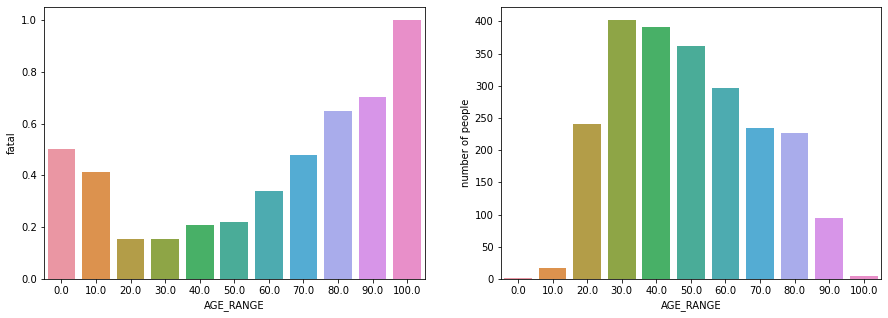

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
sns.barplot(x='AGE_YRS_range', y='fatal', data=fatal, ax=ax1)
ax1.set_xlabel('AGE_RANGE')
ax1.set_ylabel('fatal')
sns.barplot(x='index', y='AGE_YRS_range', data=age, ax=ax2)
ax2.set_xlabel('AGE_RANGE')
ax2.set_ylabel('number of people')
plt.show()

다른 나이대는 적어도 50명 이상의 데이터가 있지만, 20대 미만, 90대 이상의 데이터는 부족하다.

In [40]:
vaers_covid19_merge['VAX_DOSE_SERIES'].value_counts()

1.0    2487
2.0     425
3.0       2
5.0       2
7.0       1
4.0       1
Name: VAX_DOSE_SERIES, dtype: int64

코로나 백신은 대부분 총 2회 접종하는 백신으로, VAX_DOSE_SERIES(백신 투여량)이 2 이상인 data의 경우 이상치로 취급하여 제거하였다.

In [41]:
vaers_covid19_merge = vaers_covid19_merge[~(vaers_covid19_merge['VAX_DOSE_SERIES']>=3)]

In [135]:
#선택한 feature 추출
vaers_covid19_class = vaers_covid19_merge.loc[:,['VAX_MANU', 'VAX_DOSE_SERIES', 'STATE', 'AGE_YRS', 'SEX', 'V_ADMINBY', 'BIRTH_DEFECT', 'num_of_chronic',
                                                'pulmonary_disoreder', 'hypertension', 'high_cholesterol', 'arthritis', 'cardiac_disorder', 'diabetes',
                                                'kidney_disorder', 'depression', 'alzheimer', 'fatal', 'fatal_score']]

# vaers_covid19_regress = vaers_covid19_merge.loc[:,['VAX_MANU', 'VAX_DOSE_SERIES', 'STATE', 'AGE_YRS', 'SEX', 'V_ADMINBY', 'BIRTH_DEFECT', 'num_of_chronic',
#                                                 'pulmonary_disoreder', 'hypertension', 'high_cholesterol', 'arthritis', 'cardiac_disorder', 'diabetes',
#                                                 'kidney_disorder', 'depression', 'alzheimer', 'fatal_score']]

In [43]:
vaers_covid19_class.shape

(3586, 19)

In [136]:
#train set, valid set 나눔
from sklearn.model_selection import train_test_split

train_c, test_c = train_test_split(vaers_covid19_class, test_size=0.20, stratify=vaers_covid19_class['fatal'], random_state=11)
y_train_c = train_c['fatal']
y_train_r = train_c['fatal_score']
X_train_c = train_c.drop(columns=['fatal', 'fatal_score'])
y_test_c = test_c['fatal']
y_test_r = test_c['fatal_score']
X_test_c = test_c.drop(columns=['fatal', 'fatal_score'])

In [45]:
# train_r, test_r = train_test_split(vaers_covid19_regress, test_size=0.20, random_state=11)
# y_train_r = train_r['fatal_score']
# X_train_r = train_r.drop(columns='fatal_score')
# y_test_r = test_r['fatal_score']
# X_test_r = test_r.drop(columns='fatal_score')

#데이터 전처리

Ordinal Encoder (높은 cardinality의 feature들을 가장 잘 처리할 수 있고, 원래 순서가 있는 feature는 없기 때문에 encoder)

In [46]:
X_train_c.isna().sum() #STATE : ordinal encoder로 인해 결측값이 채워지긴 하지만, state를 알 수 없는 group또한 하나의 그룹으로 취급

VAX_MANU                  0
VAX_DOSE_SERIES         551
STATE                  1047
AGE_YRS                1071
SEX                       0
V_ADMINBY                 0
BIRTH_DEFECT              0
num_of_chronic            0
pulmonary_disoreder       0
hypertension              0
high_cholesterol          0
arthritis                 0
cardiac_disorder          0
diabetes                  0
kidney_disorder           0
depression                0
alzheimer                 0
dtype: int64

In [47]:
!pip3 install category_encoders

In [48]:
from category_encoders import OrdinalEncoder

encoder = OrdinalEncoder()

X_train_enc_c = encoder.fit_transform(X_train_c)
X_test_enc_c = encoder.transform(X_test_c)

# X_train_enc_r = encoder.fit_transform(X_train_r)
# X_test_enc_r = encoder.transform(X_test_r)

In [49]:
X_train_enc_c.isna().sum()

VAX_MANU                  0
VAX_DOSE_SERIES         551
STATE                     0
AGE_YRS                1071
SEX                       0
V_ADMINBY                 0
BIRTH_DEFECT              0
num_of_chronic            0
pulmonary_disoreder       0
hypertension              0
high_cholesterol          0
arthritis                 0
cardiac_disorder          0
diabetes                  0
kidney_disorder           0
depression                0
alzheimer                 0
dtype: int64

KNN imputer 사용 : 비슷한 정보(만성질환 종류 등)를 갖고있는 사람은 비슷한 나이대로 생각할 수 있음

In [50]:
from sklearn.impute import KNNImputer

knn_imput = KNNImputer()
X_train_imputed_c = pd.DataFrame(data=knn_imput.fit_transform(X_train_enc_c), columns=X_train_enc_c.columns, index=X_train_enc_c.index)
X_test_imputed_c = pd.DataFrame(data=knn_imput.transform(X_test_enc_c), columns=X_test_enc_c.columns, index=X_test_enc_c.index)

# X_train_imputed_r = pd.DataFrame(data=knn_imput.fit_transform(X_train_enc_r), columns=X_train_enc_r.columns, index=X_train_enc_r.index)
# X_test_imputed_r = pd.DataFrame(data=knn_imput.transform(X_test_enc_r), columns=X_test_enc_r.columns, index=X_test_enc_r.index)

In [51]:
# from sklearn.impute import SimpleImputer

# simp_imput = SimpleImputer()
# X_train_imputed_c = pd.DataFrame(data=simp_imput.fit_transform(X_train_enc_c), columns=X_train_enc_c.columns, index=X_train_enc_c.index)
# X_test_imputed_c = pd.DataFrame(data=simp_imput.transform(X_test_enc_c), columns=X_test_enc_c.columns, index=X_test_enc_c.index)

# X_train_imputed_r = pd.DataFrame(data=simp_imput.fit_transform(X_train_enc_r), columns=X_train_enc_r.columns, index=X_train_enc_r.index)
# X_test_imputed_r = pd.DataFrame(data=simp_imput.transform(X_test_enc_r), columns=X_test_enc_r.columns, index=X_test_enc_r.index)

#Classification Problem

1. 베이스라인모델

In [52]:
y_train_c.value_counts() #target중 0의 비율이 더 많으므로 기준모델의 예측값을 0으로

0    2286
1     582
Name: fatal, dtype: int64

In [53]:
y_pred_base_train_c = [0]*len(y_train_c)
y_pred_base_test_c = [0]*len(y_test_c)

In [54]:
from sklearn.metrics import accuracy_score, f1_score

print('훈련 정확도 :', accuracy_score(y_train_c, y_pred_base_train_c))
print('테스트 정확도 :', accuracy_score(y_test_c, y_pred_base_test_c))

print('훈련 f1 score :', f1_score(y_train_c, y_pred_base_train_c))
print('테스트 f1 score :', f1_score(y_test_c, y_pred_base_test_c))

훈련 정확도 : 0.797071129707113
테스트 정확도 : 0.7966573816155988
훈련 f1 score : 0.0
테스트 f1 score : 0.0


In [55]:
from sklearn.metrics import classification_report

print(classification_report(y_pred_base_test_c, y_test_c))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89       718
           1       0.00      0.00      0.00         0

    accuracy                           0.80       718
   macro avg       0.50      0.40      0.44       718
weighted avg       1.00      0.80      0.89       718



정확도는 높은 편이나 f1 score가 매우 낮음 --> 모델의 성능이 낮음 (fatal이 1인 사람을 찾고, false negative를 줄이는 것이 목적이기 때문)

2. linear model

In [56]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
log_model.fit(X_train_imputed_c, y_train_c)

y_pred_log_train_c = log_model.predict(X_train_imputed_c)
y_pred_log_test_c = log_model.predict(X_test_imputed_c)

In [57]:
print('훈련 정확도 :', accuracy_score(y_train_c, y_pred_log_train_c))
print('테스트 정확도 :', accuracy_score(y_test_c, y_pred_log_test_c))

print('훈련 f1 score :', f1_score(y_train_c, y_pred_log_train_c))
print('테스트 f1 score :', f1_score(y_test_c, y_pred_log_test_c))

훈련 정확도 : 0.8284518828451883
테스트 정확도 : 0.8203342618384402
훈련 f1 score : 0.447191011235955
테스트 f1 score : 0.416289592760181


In [58]:
print(classification_report(y_pred_log_test_c, y_test_c))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       643
           1       0.32      0.61      0.42        75

    accuracy                           0.82       718
   macro avg       0.63      0.73      0.66       718
weighted avg       0.88      0.82      0.84       718



3. Decision tree model

In [59]:
from sklearn.tree import DecisionTreeClassifier

tree_model_c = DecisionTreeClassifier(max_depth=7)
tree_model_c.fit(X_train_imputed_c, y_train_c)

y_pred_tree_train_c = tree_model_c.predict(X_train_imputed_c)
y_pred_tree_test_c = tree_model_c.predict(X_test_imputed_c)

In [60]:
print('훈련 정확도 :', accuracy_score(y_train_c, y_pred_tree_train_c))
print('테스트 정확도 :', accuracy_score(y_test_c, y_pred_tree_test_c))

print('훈련 f1 score :', f1_score(y_train_c, y_pred_tree_train_c))
print('테스트 f1 score :', f1_score(y_test_c, y_pred_tree_test_c))

훈련 정확도 : 0.8734309623430963
테스트 정확도 : 0.8119777158774373
훈련 f1 score : 0.6351758793969849
테스트 f1 score : 0.45783132530120485


In [61]:
print(classification_report(y_pred_tree_test_c, y_test_c))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       615
           1       0.39      0.55      0.46       103

    accuracy                           0.81       718
   macro avg       0.65      0.70      0.67       718
weighted avg       0.84      0.81      0.82       718



4. Random forest (Ensemble)

In [62]:
from sklearn.ensemble import RandomForestClassifier

rf_model_c = RandomForestClassifier(max_depth=7)
rf_model_c.fit(X_train_imputed_c, y_train_c)

y_pred_rf_train_c = rf_model_c.predict(X_train_imputed_c)
y_pred_rf_test_c = rf_model_c.predict(X_test_imputed_c)

In [63]:
print('훈련 정확도 :', accuracy_score(y_train_c, y_pred_rf_train_c))
print('테스트 정확도 :', accuracy_score(y_test_c, y_pred_rf_test_c))

print('훈련 f1 score :', f1_score(y_train_c, y_pred_rf_train_c))
print('테스트 f1 score :', f1_score(y_test_c, y_pred_rf_test_c))

훈련 정확도 : 0.8727336122733612
테스트 정확도 : 0.8161559888579387
훈련 f1 score : 0.5984598459845984
테스트 f1 score : 0.4107142857142857


In [64]:
print(classification_report(y_pred_rf_test_c, y_test_c))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       640
           1       0.32      0.59      0.41        78

    accuracy                           0.82       718
   macro avg       0.63      0.72      0.65       718
weighted avg       0.88      0.82      0.84       718



5. Ada boost (Ensemble)

In [65]:
from sklearn.ensemble import AdaBoostClassifier

ada_model_c = AdaBoostClassifier()
ada_model_c.fit(X_train_imputed_c, y_train_c)

y_pred_ada_train_c = ada_model_c.predict(X_train_imputed_c)
y_pred_ada_test_c = ada_model_c.predict(X_test_imputed_c)

In [66]:
print('훈련 정확도 :', accuracy_score(y_train_c, y_pred_ada_train_c))
print('테스트 정확도 :', accuracy_score(y_test_c, y_pred_ada_test_c))

print('훈련 f1 score :', f1_score(y_train_c, y_pred_ada_train_c))
print('테스트 f1 score :', f1_score(y_test_c, y_pred_ada_test_c))

훈련 정확도 : 0.8430962343096234
테스트 정확도 : 0.8203342618384402
훈련 f1 score : 0.5263157894736842
테스트 f1 score : 0.4647302904564315


In [67]:
print(classification_report(y_pred_ada_test_c, y_test_c))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       623
           1       0.38      0.59      0.46        95

    accuracy                           0.82       718
   macro avg       0.66      0.72      0.68       718
weighted avg       0.86      0.82      0.84       718



6. XG boost

In [68]:
from xgboost import XGBClassifier

xg_model_c = XGBClassifier()
xg_model_c.fit(X_train_imputed_c, y_train_c)

y_pred_xg_train_c = xg_model_c.predict(X_train_imputed_c)
y_pred_xg_test_c = xg_model_c.predict(X_test_imputed_c)

In [69]:
print('훈련 정확도 :', accuracy_score(y_train_c, y_pred_xg_train_c))
print('테스트 정확도 :', accuracy_score(y_test_c, y_pred_xg_test_c))

print('훈련 f1 score :', f1_score(y_train_c, y_pred_xg_train_c))
print('테스트 f1 score :', f1_score(y_test_c, y_pred_xg_test_c))

훈련 정확도 : 0.8594839609483961
테스트 정확도 : 0.8356545961002786
훈련 f1 score : 0.5689839572192513
테스트 f1 score : 0.4913793103448276


In [70]:
print(classification_report(y_pred_xg_test_c, y_test_c))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       632
           1       0.39      0.66      0.49        86

    accuracy                           0.84       718
   macro avg       0.67      0.76      0.70       718
weighted avg       0.88      0.84      0.85       718



기준모델과 linear model과 비교하여 정확도와 recall, f1 score 모두 증가하였다.

~~Light GBM #10,000개 이상 샘플 가진 데이터에 사용 권함~~

여기서는 xgboost 모델의 recall과 f1 score가 가장 높았으므로 random forest 모델을 사용

7. 과적합문제 해결 

(여기서는 randomized search cv를 사용하여 hyperparameter를 조정하여 해결)

In [71]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest

# vc_c = y_train_c.value_counts(normalize=True).tolist()
# ratio_c = {0:vc_c[1], 1:vc_c[0]} #target의 비율이 맞지 않으므로 weight 가해줌

# pipe_c = make_pipeline(
#     KNNImputer(),
#     RandomForestClassifier(class_weight=ratio_c)
# )

# dists_c = {
#     'knnimputer__n_neighbors' : range(3, 7)
#     , 'knnimputer__weights' : ['uniform', 'distance']
#     , 'randomforestclassifier__n_estimators' : range(50, 200)
#     , 'randomforestclassifier__max_depth' : range(5, 20)
#     , 'randomforestclassifier__max_features' : ['auto', 'sqrt', 'log2']
#     # , 'randomforestclassifier__min_samples_leaf' : range(5, 50)
#     , 'randomforestclassifier__min_samples_split' : range(5, 50)
#     , 'randomforestclassifier__criterion' : ['gini', 'entropy']
# }

# clf_c = RandomizedSearchCV(
#     pipe_c, param_distributions=dists_c,
#     n_iter=20, #hyper parameter 조합 개수
#     cv=5, #cross validation 개수
#     scoring='f1',
#     verbose=1, #verbose : 진행상황 실시간으로 알려주는 정도 (숫자 커질수록 자세하게)
#     n_jobs=1
# )

# clf_c.fit(X_train_enc_c, y_train_c)

In [72]:
vc_c = y_train_c.value_counts(normalize=True).tolist()
ratio_c = float(vc_c[0]/vc_c[1]) #target의 비율이 맞지 않으므로 weight 가해줌

pipe_c = make_pipeline(
    KNNImputer(),
    # SelectKBest(),
    XGBClassifier(scale_pos_weight=ratio_c)
)

dists_c = {
    'knnimputer__n_neighbors' : range(3, 7)
    # , 'selectkbest__k' : range(5,18)
    , 'knnimputer__weights' : ['uniform', 'distance']
    , 'xgbclassifier__max_depth' : range(3, 15)
    , 'xgbclassifier__learning_rate' : uniform(0, 1)
    , 'xgbclassifier__n_estimators' : range(50, 300)
}

clf_c = RandomizedSearchCV(
    pipe_c, param_distributions=dists_c,
    n_iter=20, #hyper parameter 조합 개수
    cv=5, #cross validation 개수
    scoring='f1_weighted',
    verbose=1,
    n_jobs=1
)

clf_c.fit(X_train_enc_c, y_train_c)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('knnimputer',
                                              KNNImputer(add_indicator=False,
                                                         copy=True,
                                                         metric='nan_euclidean',
                                                         missing_values=nan,
                                                         n_neighbors=5,
                                                         weights='uniform')),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            colsample_bylevel=1,
                                                            colsample_bynode=1,
               

In [73]:
pipe_best_c = clf_c.best_estimator_

pipe_best_c.fit(X_train_enc_c, y_train_c)
y_pred_cv_test_c = pipe_best_c.predict(X_test_enc_c)

print('테스트 정확도 :', accuracy_score(y_test_c, y_pred_cv_test_c))
print('테스트 f1 score :', f1_score(y_test_c, y_pred_cv_test_c))

테스트 정확도 : 0.8008356545961003
테스트 f1 score : 0.49110320284697506


In [74]:
print(classification_report(y_pred_cv_test_c, y_test_c))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       583
           1       0.47      0.51      0.49       135

    accuracy                           0.80       718
   macro avg       0.68      0.69      0.68       718
weighted avg       0.81      0.80      0.80       718



8. recall 값 조정 (threshold 사용)

In [75]:
from sklearn.metrics import roc_curve

y_pred_cv_train_c_proba = pipe_best_c.predict_proba(X_train_enc_c)[:,1]
fpr, tpr, thresholds = roc_curve(y_train_c, y_pred_cv_train_c_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

In [76]:
optimal_threshold

0.5540362

In [77]:
y_pred_cv_train_c_proba = pipe_best_c.predict_proba(X_train_enc_c)[:,1]

for i in range(len(y_pred_cv_train_c_proba)) :
  if y_pred_cv_train_c_proba[i]<optimal_threshold :
    y_pred_cv_train_c_proba[i] = 0
  else :
    y_pred_cv_train_c_proba[i] = 1

In [78]:
print('훈련 정확도 :', accuracy_score(y_train_c, y_pred_cv_train_c_proba))
print('훈련 f1 score :', f1_score(y_train_c, y_pred_cv_train_c_proba))

훈련 정확도 : 0.9846582984658299
훈련 f1 score : 0.9627749576988155


In [79]:
y_pred_cv_test_c_proba = pipe_best_c.predict_proba(X_test_enc_c)[:,1]

for i in range(len(y_pred_cv_test_c_proba)) :
  if y_pred_cv_test_c_proba[i]<optimal_threshold :
    y_pred_cv_test_c_proba[i] = 0
  else :
    y_pred_cv_test_c_proba[i] = 1

In [80]:
print('테스트 정확도 :', accuracy_score(y_test_c, y_pred_cv_test_c_proba))
print('테스트 f1 score :', f1_score(y_test_c, y_pred_cv_test_c_proba))

테스트 정확도 : 0.8050139275766016
테스트 f1 score : 0.4890510948905109


In [81]:
print(classification_report(y_pred_cv_test_c_proba, y_test_c))

              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88       590
         1.0       0.46      0.52      0.49       128

    accuracy                           0.81       718
   macro avg       0.68      0.69      0.68       718
weighted avg       0.82      0.81      0.81       718



#Permutation importance

In [82]:
# !pip install pdpbox

In [83]:
# !pip3 install eli5

In [84]:
import eli5
from eli5.sklearn import PermutationImportance

permuter_c = PermutationImportance(
    pipe_best_c.named_steps['xgbclassifier'],
    scoring='f1_weighted',
    n_iter=5,
    random_state=11
)

X_test_transformed_c = pipe_best_c.named_steps['knnimputer'].transform(X_test_enc_c)
permuter_c.fit(X_test_transformed_c, y_test_c);

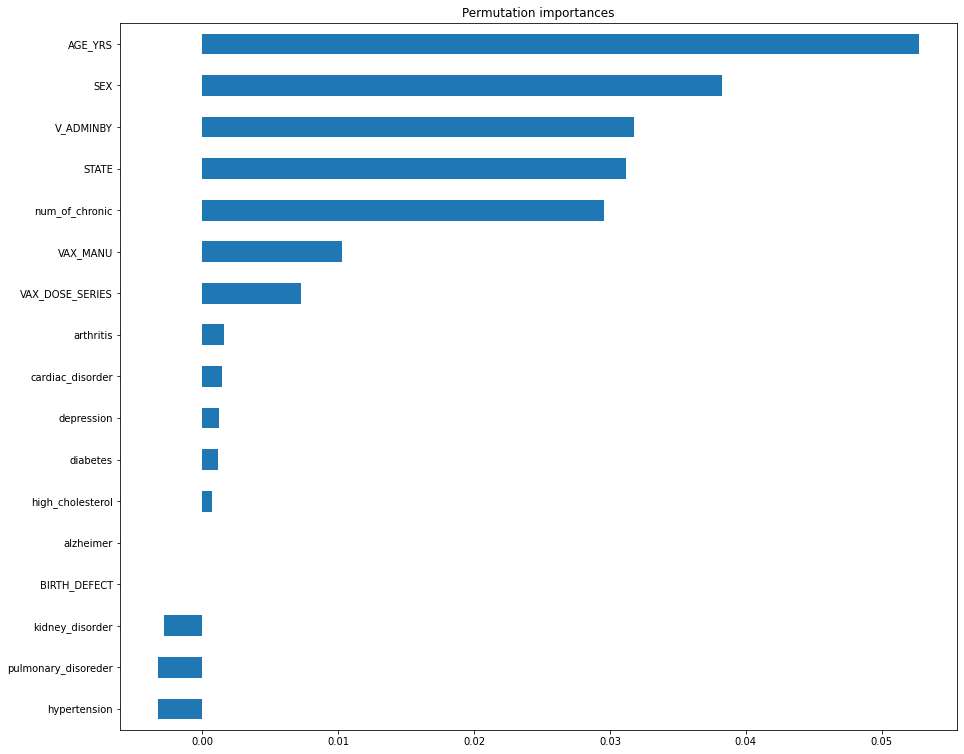

In [85]:
plt.figure(figsize=(15,13))

feature_names_c = X_test_enc_c.columns.tolist()
permut_importances_c = pd.Series(permuter_c.feature_importances_, feature_names_c).sort_values()

permut_importances_c.sort_values().plot.barh();
plt.title("Permutation importances");

전반적으로 만성질환의 유무는 딱히 부작용을 일으킬 가능성을 높이지 않았다. 따라서 부작용을 일으킬 가능성에 만성 질환은 큰 연관성이 없다고 판단할 수 있다.

In [86]:
#permutation importance에서 negative한 값을 보인 feature 제거하여 다시 모델에 대입

X_train_select_c = X_train_enc_c.drop(columns=['kidney_disorder', 'pulmonary_disoreder', 'hypertension'])
X_test_select_c = X_test_enc_c.drop(columns=['kidney_disorder', 'pulmonary_disoreder', 'hypertension'])

In [87]:
pipe_best_c.fit(X_train_select_c, y_train_c)

Pipeline(memory=None,
         steps=[('knnimputer',
                 KNNImputer(add_indicator=False, copy=True,
                            metric='nan_euclidean', missing_values=nan,
                            n_neighbors=4, weights='uniform')),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0,
                               learning_rate=0.30166947963117974,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=None,
                               n_estimators=228, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=3.927835051546392, seed=None,
                               silent=Non

In [88]:
y_pred_select_test_c = pipe_best_c.predict(X_test_select_c)

print('테스트 정확도 :', accuracy_score(y_test_c, y_pred_select_test_c))
print('테스트 f1 score :', f1_score(y_test_c, y_pred_select_test_c))

테스트 정확도 : 0.8091922005571031
테스트 f1 score : 0.5259515570934254


In [89]:
print(classification_report(y_pred_cv_test_c, y_test_c))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       583
           1       0.47      0.51      0.49       135

    accuracy                           0.80       718
   macro avg       0.68      0.69      0.68       718
weighted avg       0.81      0.80      0.80       718



In [90]:
y_pred_select_train_c_proba = pipe_best_c.predict_proba(X_train_select_c)[:,1]
fpr, tpr, thresholds = roc_curve(y_train_c, y_pred_select_train_c_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

In [91]:
for i in range(len(y_pred_select_train_c_proba)) :
  if y_pred_select_train_c_proba[i]<optimal_threshold :
    y_pred_select_train_c_proba[i] = 0
  else :
    y_pred_select_train_c_proba[i] = 1

In [92]:
y_pred_select_test_c_proba = pipe_best_c.predict_proba(X_test_select_c)[:,1]

for i in range(len(y_pred_select_test_c_proba)) :
  if y_pred_select_test_c_proba[i]<optimal_threshold :
    y_pred_select_test_c_proba[i] = 0
  else :
    y_pred_select_test_c_proba[i] = 1

In [93]:
print('테스트 정확도 :', accuracy_score(y_test_c, y_pred_select_test_c_proba))
print('테스트 f1 score :', f1_score(y_test_c, y_pred_select_test_c_proba))

테스트 정확도 : 0.807799442896936
테스트 f1 score : 0.5140845070422535


In [94]:
print(classification_report(y_pred_select_test_c_proba, y_test_c))

              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88       580
         1.0       0.50      0.53      0.51       138

    accuracy                           0.81       718
   macro avg       0.69      0.70      0.70       718
weighted avg       0.81      0.81      0.81       718



In [95]:
# encoder.category_mapping

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


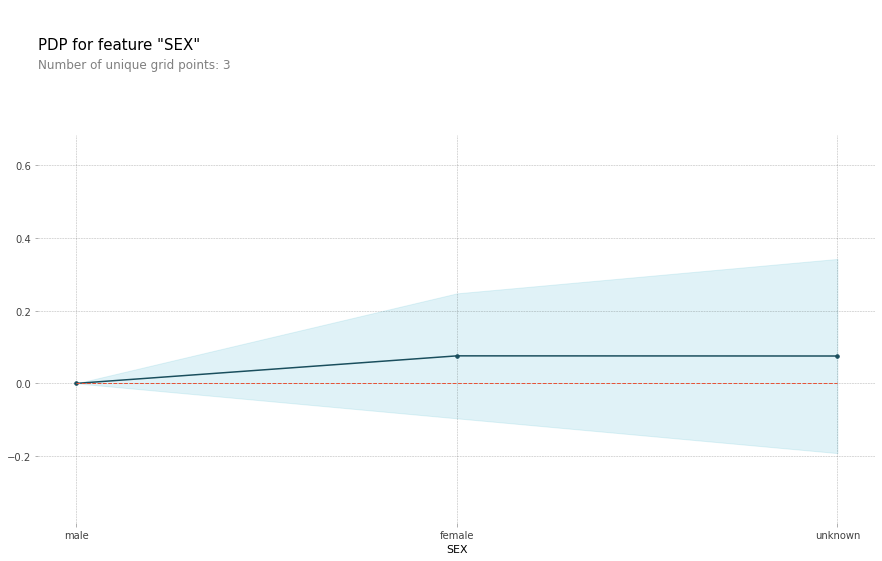

In [96]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'SEX'

isolated_c = pdp_isolate(
    model=pipe_best_c, 
    dataset=X_test_select_c, 
    model_features=X_test_select_c.columns, 
    feature=feature
)

pdp_plot(isolated_c, feature_name=feature)
plt.xticks([1, 2, 3], ['male', 'female', 'unknown']);

남성보다 여성에서 부작용 발생 가능성이 약간 더 높았다.

https://news.kbs.co.kr/news/view.do?ncd=5091009

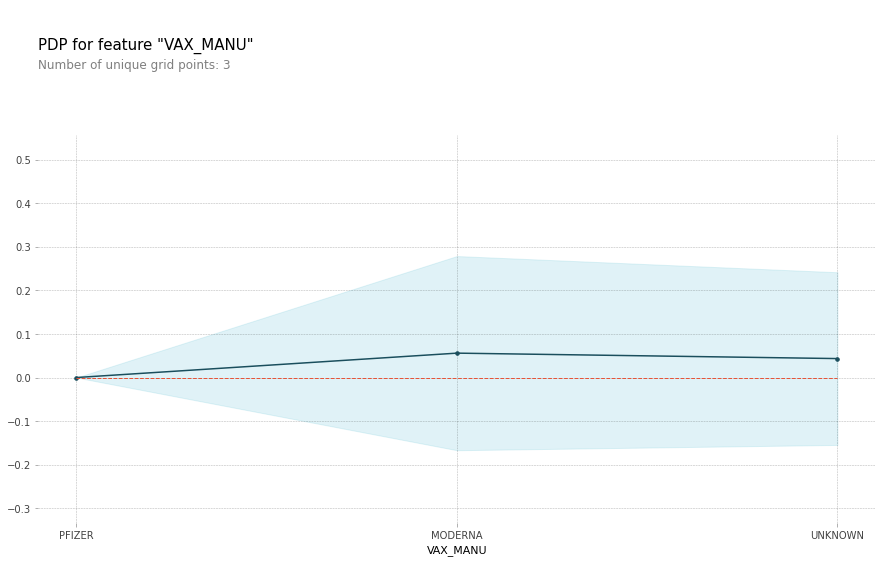

In [97]:
feature = 'VAX_MANU'

isolated_c = pdp_isolate(
    model=pipe_best_c, 
    dataset=X_test_select_c, 
    model_features=X_test_select_c.columns, 
    feature=feature
)

pdp_plot(isolated_c, feature_name=feature)

plt.xticks([1, 2, 3], ['PFIZER', 'MODERNA', 'UNKNOWN']);

Moderna을 접종받은 사람이 부작용이 발생할 가능성이 더 높았다.

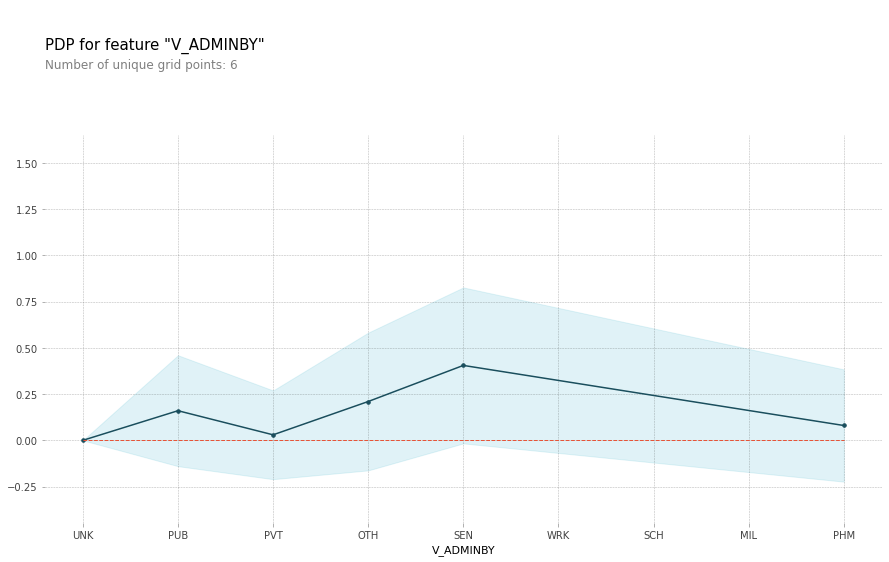

In [98]:
feature = 'V_ADMINBY'

isolated_c = pdp_isolate(
    model=pipe_best_c, 
    dataset=X_test_select_c, 
    model_features=X_test_select_c.columns, 
    feature=feature
)

pdp_plot(isolated_c, feature_name=feature)
plt.xticks([1, 2, 3,4,5,6,7,8,9], ['UNK', 'PUB', 'PVT', 'OTH', 'SEN', 'WRK', 'SCH', 'MIL', 'PHM']);

SEN(Nursing home or senior
living facility) 에서 보관한 백신에서 높은 확률로 부작용이 발생했다. 우연일 수도 있지만, 백신 관리에 있어 문제가 있었을 수 있음을 의심해 볼 수 있을 것이다.

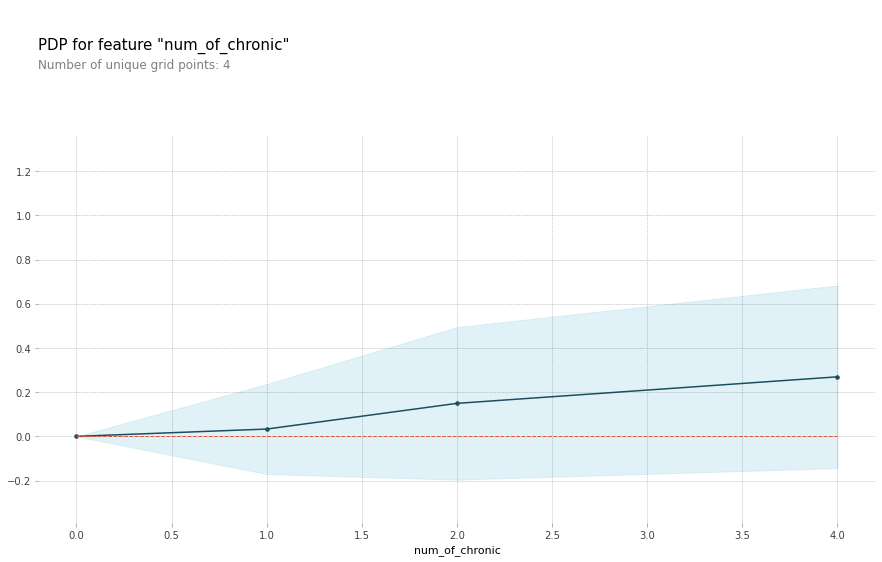

In [99]:
feature = 'num_of_chronic'

isolated_c = pdp_isolate(
    model=pipe_best_c, 
    dataset=X_test_select_c, 
    model_features=X_test_select_c.columns, 
    feature=feature,
    grid_type='percentile',
    num_grid_points=20
)

pdp_plot(isolated_c, feature_name=feature);

여러가지 만성질환이 함께 있을때 부작용을 일으킬 가능성이 가장 높았다.

In [100]:
knn_imput = pipe_best_c.named_steps['knnimputer']
X_test_imput_c = pd.DataFrame(data=knn_imput.transform(X_test_select_c), columns=X_test_select_c.columns)

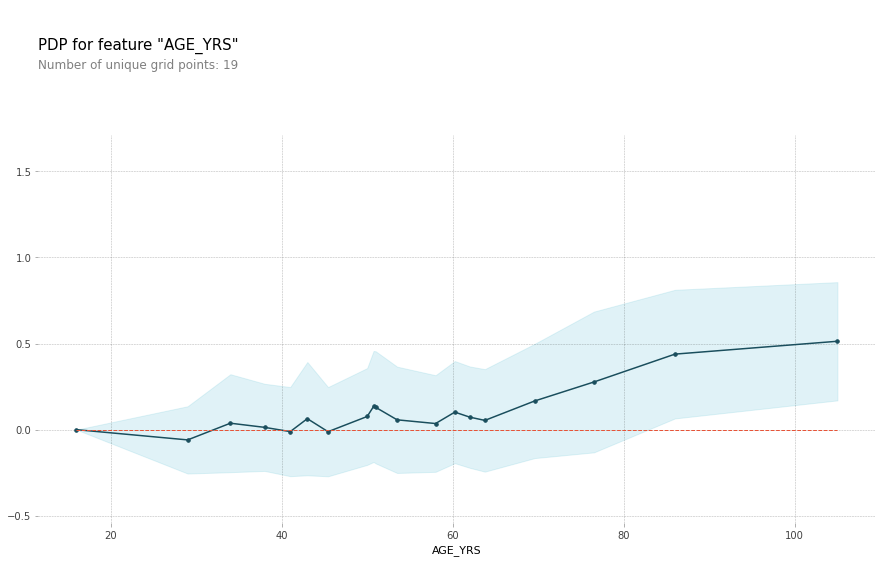

In [101]:
feature = 'AGE_YRS'

isolated = pdp_isolate(
    model=pipe_best_c, 
    dataset=X_test_imput_c, 
    model_features=X_test_imput_c.columns, 
    feature=feature,
    grid_type='percentile',
    num_grid_points=20
)

pdp_plot(isolated, feature_name=feature);

약 65세 이상부터 부작용이 발생할 가능성이 크게 높아졌다.

http://www.monews.co.kr/news/articleView.html?idxno=214007

#Regression model

앞선 결과를 하나의 feature로 사용하여, 부작용이 발생할 가능성이 높은 사람들 중에서도 그 정도를 1(심각)과 2(매우 심각)로 나누어 예측

In [102]:
knn_imput = pipe_c.named_steps['knnimputer']
knn_imput.fit(X_train_enc_c, y_train_c)
X_train_imp_c = knn_imput.transform(X_train_enc_c)
X_test_imp_c = knn_imput.transform(X_test_enc_c)
X_train_imp_c = pd.DataFrame(data=X_train_imp_c, index=X_train_enc_c.index, columns=X_train_enc_c.columns)
X_test_imp_c = pd.DataFrame(data=X_test_imp_c, index=X_test_enc_c.index, columns=X_test_enc_c.columns)

In [103]:
#데이터에 calssification 결과값 추가 
X_train_imp_c['fatal_pred'] = y_pred_select_train_c_proba
X_test_imp_c['fatal_pred'] = y_pred_select_test_c_proba

In [137]:
#데이터에 실제 regression 값 추가
X_train_imp_c['fatal_score'] = y_train_r
X_test_imp_c['fatal_score'] = y_test_r

In [138]:
imp_c = pd.concat([X_train_imp_c, X_test_imp_c])
train_r, test_r = train_test_split(imp_c, test_size=0.20, stratify=imp_c['fatal_pred'], random_state=11)

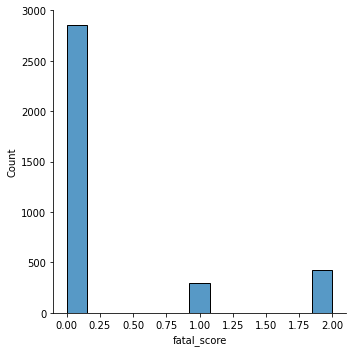

In [139]:
sns.displot(imp_c['fatal_score']);

In [140]:
#심각한 부작용 가능성 있음/없음을 feature로 채택하고 X, y로 나누어 진행
# X_train_r0 = train_r[train_r['fatal_pred']==0]
# X_test_r0 = test_r[test_r['fatal_pred']==0]

# X_train_r = train_r[train_r['fatal_pred']==1]
# X_test_r = test_r[test_r['fatal_pred']==1]

y_train_r = train_r['fatal_score']
y_test_r = test_r['fatal_score']

X_train_r = train_r.drop(columns=['fatal_score'])
X_test_r = test_r.drop(columns=['fatal_score'])


1. 베이스라인모델

In [141]:
y_pred_base_train_r = [y_train_r.mean()]*len(y_train_r)
y_pred_base_test_r = [y_test_r.mean()]*len(y_test_r)

In [142]:
from sklearn.metrics import r2_score, mean_absolute_error

print('훈련 에러 :', mean_absolute_error(y_train_r, y_pred_base_train_r))
print('테스트 에러 :', mean_absolute_error(y_test_r, y_pred_base_test_r))

print('훈련 R2 score :', r2_score(y_train_r, y_pred_base_train_r))
print('테스트 R2 score :', r2_score(y_test_r, y_pred_base_test_r))

훈련 에러 : 0.5194528573846163
테스트 에러 : 0.49108091960801054
훈련 R2 score : 0.0
테스트 R2 score : 0.0


2. Linear Regression

In [143]:
from sklearn.linear_model import LinearRegression

lin_model_r = LinearRegression()
lin_model_r.fit(X_train_r, y_train_r)

y_pred_lin_train_r = lin_model_r.predict(X_train_r)
y_pred_lin_test_r = lin_model_r.predict(X_test_r)

In [144]:
print('훈련 에러 :', mean_absolute_error(y_train_r, y_pred_lin_train_r))
print('테스트 에러 :', mean_absolute_error(y_test_r, y_pred_lin_test_r))

print('훈련 R2 score :', r2_score(y_train_r, y_pred_lin_train_r))
print('테스트 R2 score :', r2_score(y_test_r, y_pred_lin_test_r))

훈련 에러 : 0.19497120820002228
테스트 에러 : 0.21646686995353687
훈련 R2 score : 0.7062151257716913
테스트 R2 score : 0.567264980211597


In [145]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
log_model.fit(X_train_r, y_train_r)

y_pred_log_train_r = log_model.predict(X_train_r)
y_pred_log_test_r = log_model.predict(X_test_r)

In [146]:
print('훈련 에러 :', mean_absolute_error(y_train_r, y_pred_log_train_r))
print('테스트 에러 :', mean_absolute_error(y_test_r, y_pred_log_test_r))

print('훈련 R2 score :', r2_score(y_train_r, y_pred_log_train_r))
print('테스트 R2 score :', r2_score(y_test_r, y_pred_log_test_r))

훈련 에러 : 0.10495118549511855
테스트 에러 : 0.14623955431754876
훈련 R2 score : 0.66513005971068
테스트 R2 score : 0.4809832753395442


4. Tree-based model

In [147]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=3)
tree_model.fit(X_train_r, y_train_r)
y_pred_tree_train_r = tree_model.predict(X_train_r)
print('훈련 에러: ', mean_absolute_error(y_train_r, y_pred_tree_train_r))
print('훈련 R2 :', r2_score(y_train_r, y_pred_tree_train_r))

훈련 에러:  0.016924963278993146
훈련 R2 : 0.9686011819828388


In [148]:
y_pred_tree_test_r = tree_model.predict(X_test_r)
print('테스트 에러: ', mean_absolute_error(y_test_r, y_pred_tree_test_r))
print('테스트 R2 :', r2_score(y_test_r, y_pred_tree_test_r))

테스트 에러:  0.21553821253961547
테스트 R2 : 0.30201284106848725


과적합 발생

In [149]:
tree_model = DecisionTreeRegressor(random_state=3, max_depth=5)
tree_model.fit(X_train_r, y_train_r)
y_pred_tree_train_r = tree_model.predict(X_train_r)
print('훈련 에러: ', mean_absolute_error(y_train_r, y_pred_tree_train_r))
print('훈련 R2 :', r2_score(y_train_r, y_pred_tree_train_r))

훈련 에러:  0.1427203725970232
훈련 R2 : 0.759121805355071


In [150]:
y_pred_tree_test_r = tree_model.predict(X_test_r)
print('테스트 에러: ', mean_absolute_error(y_test_r, y_pred_tree_test_r))
print('테스트 R2 :', r2_score(y_test_r, y_pred_tree_test_r))

테스트 에러:  0.18737910700441315
테스트 R2 : 0.5548579668338588


5. Random forest (ensemble)

In [151]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(max_depth=5, n_estimators=5)
rf_model.fit(X_train_r, y_train_r)
y_pred_rf_train_r = rf_model.predict(X_train_r)
print('훈련 에러: ', mean_absolute_error(y_train_r, y_pred_rf_train_r))
print('훈련 R2 :', r2_score(y_train_r, y_pred_rf_train_r))

훈련 에러:  0.13851407913894223
훈련 R2 : 0.7653224652050846


In [152]:
y_pred_rf_test_r = rf_model.predict(X_test_r)
print('테스트 에러: ', mean_absolute_error(y_test_r, y_pred_rf_test_r))
print('테스트 R2 :', r2_score(y_test_r, y_pred_rf_test_r))

테스트 에러:  0.18338820993522081
테스트 R2 : 0.559704615086944


6. boosting



In [153]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=3, max_depth=3, learning_rate=0.2)
xgb_model.fit(X_train_r, y_train_r)
y_pred_xgb_train_r = xgb_model.predict(X_train_r)
print('훈련 에러: ', mean_absolute_error(y_train_r, y_pred_xgb_train_r))
print('훈련 R2 :', r2_score(y_train_r, y_pred_xgb_train_r))

[07:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
훈련 에러:  0.1330690851936447
훈련 R2 : 0.7996060747365291


In [154]:
y_pred_xgb_test_r = xgb_model.predict(X_test_r)
print('테스트 에러: ', mean_absolute_error(y_test_r, y_pred_xgb_test_r))
print('테스트 R2 :', r2_score(y_test_r, y_pred_xgb_test_r))

테스트 에러:  0.1908745268842304
테스트 R2 : 0.5751241441315671


7. RandomizedSearchCV

In [155]:
pipe_r = make_pipeline(
    # SelectKBest(), #selectkbest후 성능에 큰 차이가 없었음
    RandomForestRegressor()
)

dists_r = {
    # 'selectkbest__k' : range(5,18),
    'randomforestregressor__n_estimators' : range(50, 200),
    'randomforestregressor__max_depth' : range(5, 20),
    'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
    # 'randomforestregressor__min_samples_leaf' : range(5, 50),
    'randomforestregressor__min_samples_split' : range(5, 50),
    'randomforestregressor__criterion' : ['mse', 'mae']
}

clf_r = RandomizedSearchCV(
    pipe_r, param_distributions=dists_r,
    n_iter=20,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=1
)

clf_r.fit(X_train_r, y_train_r)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('randomforestregressor',
                                              RandomForestRegressor(bootstrap=True,
                                                                    ccp_alpha=0.0,
                                                                    criterion='mse',
                                                                    max_depth=None,
                                                                    max_features='auto',
                                                                    max_leaf_nodes=None,
                                                                    max_samples=None,
                                                                    min_impurity_decrease=0.0,
                                                                    min_impurity_split=None,
                                                

In [156]:
print('최적 hyperparameter 조합 :', clf_r.best_params_)

최적 hyperparameter 조합 : {'randomforestregressor__n_estimators': 195, 'randomforestregressor__min_samples_split': 32, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 18, 'randomforestregressor__criterion': 'mae'}


In [157]:
pipe_best_r = clf_r.best_estimator_

y_pred_cv_test_r = pipe_best_r.predict(X_test_r)
print('테스트 에러: ', mean_absolute_error(y_test_r, y_pred_cv_test_r))
print('테스트 R2 :', r2_score(y_test_r, y_pred_cv_test_r))

테스트 에러:  0.16238482965502463
테스트 R2 : 0.537605229647213


linear model, 기준 모델과 비교하여 더 좋은 성능의 모델을 구할 수 있었다.

#Permutation importance

In [158]:
permuter_r = PermutationImportance(
    pipe_best_r.named_steps['randomforestregressor'],
    scoring='neg_mean_absolute_error',
    n_iter=5,
    random_state=11
)

pipe_best_r.fit(X_train_r, y_train_r)
permuter_r.fit(X_test_r, y_test_r);

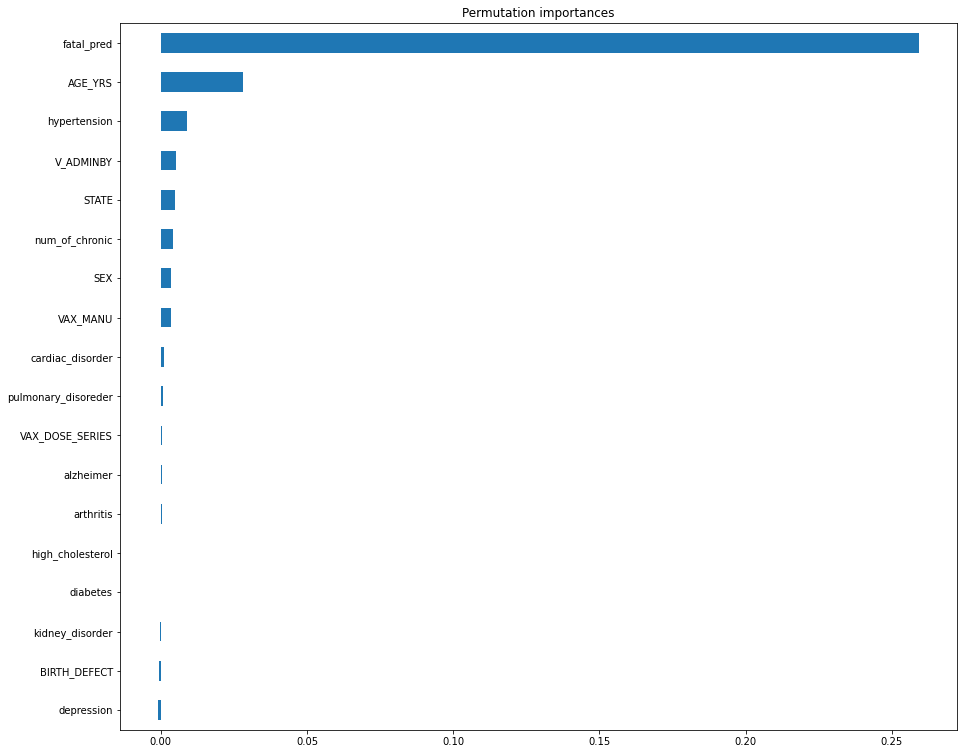

In [159]:
plt.figure(figsize=(15,13))

feature_names_r = X_test_r.columns.tolist()
permut_importances_r = pd.Series(permuter_r.feature_importances_, feature_names_r).sort_values()

permut_importances_r.sort_values().plot.barh();
plt.title("Permutation importances");

In [160]:
# !pip install pdpbox

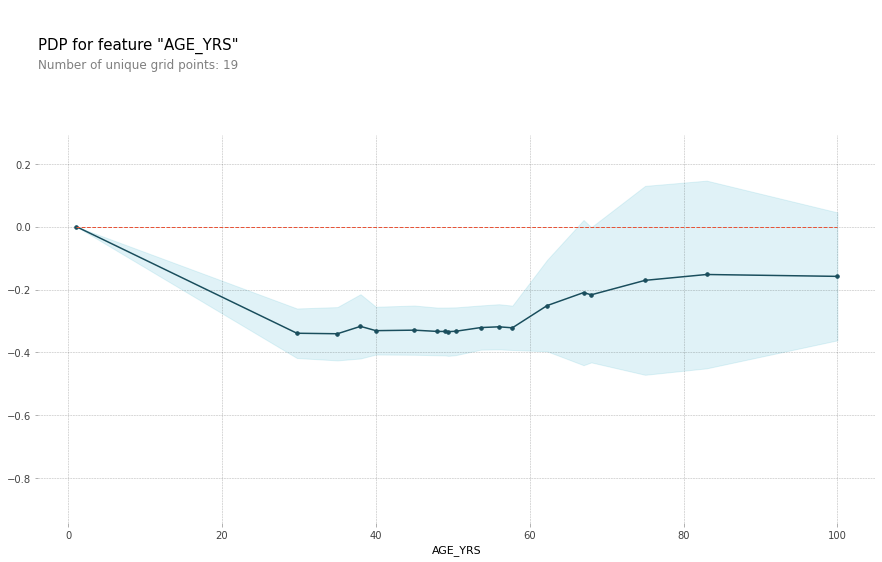

In [161]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'AGE_YRS'

isolated = pdp_isolate(
    model=pipe_best_r, 
    dataset=X_test_r, 
    model_features=X_test_r.columns, 
    feature=feature,
    grid_type='percentile',
    num_grid_points=20
)

pdp_plot(isolated, feature_name=feature);

20대~50대 사이에 있는 접종대상자일수록 부작용이 심각할 가능성이 크게 줄어듬

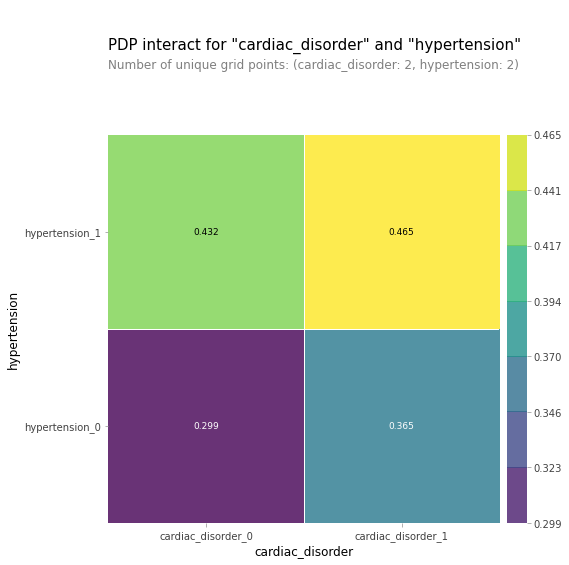

In [162]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['cardiac_disorder', 'hypertension']

interaction = pdp_interact(
    model=pipe_best_r, 
    dataset=X_test_r,
    model_features=X_test_r.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

앞선 분석에서는 만성질환과의 연관성이 떨어져있었는데, 이것은 부작용을 겪을 가능성은 만성질환과 크게 상관이 없음을 시사한다.

하지만 부작용을 겪는 사람들 중에서는 만성질환을 겪을 수록 그 부작용의 정도가 심각하다는 것을 알 수 있다. 특히 그 연관성이 높게 나타난 것은 심혈관계 질환과 고혈압이었다. 둘 다 가지고 있을 수록 심각한 부작용을 겪을 가능성이 증가하였다.

In [163]:
!pip install shap

In [166]:
import shap

row = X_test_r.loc[[3231]]
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, features=row)

실제 target값이 0 인 샘플에 대해서, 예측값은 0.01로, 

Positive 영향을 가장 많이 주는 요인 :
1. fatal_pred : 0 (이전 분류에서 0으로 예측된 값)
2. age_yrs : 49.4
3. sex : 1 (남성)

In [170]:
row = X_test_r.loc[[1044]]
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, features=row)

실제 target값이 1 인 샘플에 대해서, 예측값은 0.93으로,

Positive 영향을 가장 많이 주는 요인 :
1. fatal_pred : 1 (이전 분류에서 1로 예측된 값)
2. State : 46 (ND:North Dakota)

Negative 영향을 가장 많이 주는 요인 :
1. age_yrs : 28 (나이가 28세)


In [175]:
row = X_test_r.loc[[2201]]
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, features=row)

실제 target값이 2 인 샘플에 대해서, 예측값은 1.92로,

Positive 영향을 가장 많이 주는 요인 :
1. fatal_pred : 1 (이전 분류에서 1로 예측된 값)
2. age_yrs : 88 (나이가 88세)
3. state : 46(ND:North Dakota)